# Acne Dtection using using VGG16

# Training and Validation

### Importing Dependencies

In [1]:
# Import the VGG16 model with pre-trained weights from Keras applications
# VGG Stands for:  Visual Geometry Group (VGG)
from tensorflow.keras.applications import VGG16

# Import the Model class to build and manage our neural network
from tensorflow.keras.models import Model

# Import Dense and Flatten layers for building our custom layers
from tensorflow.keras.layers import Dense, Flatten

# Import ImageDataGenerator for data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Adam optimizer for compiling the model
from tensorflow.keras.optimizers import Adam


2024-08-05 02:13:05.392515: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 02:13:05.493146: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 02:13:05.589809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 02:13:05.681837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 02:13:05.706153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 02:13:05.849323: I tensorflow/core/platform/cpu_feature_gu

### Load the pre-trained VGG16 model, excluding the top layers
Loading the pre-trained VGG16 model without its top layers lets you use its powerful feature-detecting abilities and then customize the final part to fit your specific task, saving time and improving accuracy.

In [2]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### Freeze the base model layers to prevent them from being updated during training
Freezing the base model layers prevents them from being updated during training so that their learned features remain intact, allowing you to only train the new layers you've added, which speeds up training and reduces the risk of overfitting on your new dataset.

In [3]:
for layer in base_model.layers:
    layer.trainable = False

### Add custom classification layers

In [4]:
# Flatten the output from the VGG16 model to convert the 2D feature maps into a 1D vector
# This step is necessary before feeding the output into fully connected (Dense) layers
x = Flatten()(base_model.output)

# Add a Dense layer with 256 units and ReLU activation function
# The ReLU function introduces non-linearity and allows the model to learn more complex patterns
x = Dense(256, activation='relu')(x)

# Add a final Dense layer with a single unit and sigmoid activation function
# The sigmoid function outputs a probability score between 0 and 1 for binary classification
# This layer is used to determine the presence or absence of the target class (e.g., acne vs. no acne)
x = Dense(1, activation='sigmoid')(x)


### Create the full model
Create a new Model object by specifying the input from the base VGG16 model and the output from the custom layers
This combines the feature extraction layers from VGG16 with the newly added classification layers into a single model.

In [5]:
model = Model(inputs=base_model.input, outputs=x)

### Compile the model

Compile the model with the Adam optimizer, binary cross-entropy loss function, and accuracy as a metric
The Adam optimizer is used with a learning rate of 0.0001 to adjust the weights during training
The binary cross-entropy loss function is suitable for binary classification tasks
The model's performance will be evaluated using accuracy, which measures the proportion of correct predictions

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

### Data augmentation and generators for training and validation

In [7]:
# Create an ImageDataGenerator instance for the training dataset with data augmentation
# This instance will preprocess and augment the training images to improve model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to the range [0, 1]
    rotation_range=30,        # Randomly rotate images by up to 30 degrees
    shear_range=0.2,          # Apply random shearing transformations
    zoom_range=0.2,           # Apply random zoom
    horizontal_flip=True      # Randomly flip images horizontally
)

# Create an ImageDataGenerator instance for the validation dataset without data augmentation
# This instance will only rescale the pixel values for consistent evaluation of the model
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented image data from the training directory
# The images will be resized to 224x224 pixels, and the batches will contain 32 images each
# The class_mode='binary' indicates that the labels are binary (e.g., presence or absence of acne)
train_generator = train_datagen.flow_from_directory(
    "dataset/training/",     # Path to the training dataset directory
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,           # Number of images to return in each batch
    class_mode='binary'      # Binary classification labels
)

# Generate batches of image data from the validation directory
# The images will be resized to 224x224 pixels, and the batches will contain 32 images each
# The class_mode='binary' indicates that the labels are binary
val_generator = val_datagen.flow_from_directory(
    "dataset/validation/",   # Path to the validation dataset directory
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,           # Number of images to return in each batch
    class_mode='binary'      # Binary classification labels
)


Found 1646 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


### Train the model

In [8]:
# Train the model using the training data generator and validate it using the validation data generator
# The model will be trained for 10 epochs, which means the entire dataset will be processed 10 times
# The validation_data parameter specifies the validation data generator to evaluate the model's performance after each epoch
model.fit(
    train_generator,          # Data generator for training images
    epochs=25,                # Number of epochs to train the model
    validation_data=val_generator  # Data generator for validation images to evaluate model performance
)


Epoch 1/25


/home/agbor/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/step - accuracy: 0.7359 - loss: 0.5128 - val_accuracy: 0.9196 - val_loss: 0.2452
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.9166 - loss: 0.2203 - val_accuracy: 0.9196 - val_loss: 0.2031
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.9359 - loss: 0.1755 - val_accuracy: 0.8393 - val_loss: 0.2997
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 316s 6s/step - accuracy: 0.9346 - loss: 0.1548 - val_accuracy: 0.8125 - val_loss: 0.3321
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.9444 - loss: 0.1489 - val_accuracy: 0.9196 - val_loss: 0.1907
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9524 - loss: 0.1262 - val_accuracy: 0.9375 - val_loss: 0.1693
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - accuracy: 0.9667 - loss: 0.0993 - val_accuracy: 0.8661 - val_loss: 0.2773
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.9673 - loss: 0.0936 - val_accuracy: 0.9286 - val_loss: 0.

### Model Evaluation

In [9]:
# Create a data generator for the testing dataset
# This generator will preprocess the testing images, resize them to 224x224 pixels, and return them in batches
# The shuffle=False parameter ensures that the order of images is not changed, which is important for evaluation
test_generator = val_datagen.flow_from_directory(
    "dataset/testing/",       # Path to the testing dataset directory
    target_size=(224, 224),   # Resize images to 224x224 pixels
    batch_size=32,            # Number of images to return in each batch
    class_mode='binary',      # Binary classification labels
    shuffle=False             # Do not shuffle the order of images for consistent evaluation
)

# Evaluate the model's performance on the testing dataset
# The evaluate method returns the loss and accuracy of the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy and test loss
# These metrics provide insights into the model's performance on unseen data
print(f"Test Accuracy: {test_accuracy:.2f}")  # Print the test accuracy, rounded to two decimal places
print(f"Test Loss: {test_loss:.2f}")         # Print the test loss, rounded to two decimal places


Found 96 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.8815 - loss: 0.3069
Test Accuracy: 0.93
Test Loss: 0.20


### Confusion Matrix

In [10]:
# Import functions for evaluating classification performance from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels from the test generator
# This will be an array of true class labels for the test dataset
true_labels = test_generator.classes

# Generate predictions for the test dataset using the trained model
# This method returns the predicted probabilities for each class
predictions = model.predict(test_generator)

# Convert the predicted probabilities to binary labels
# Using a threshold of 0.5 for binary classification
# Reshape the array to ensure it matches the shape of true_labels
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

# Compute the confusion matrix to evaluate the performance of the model
# The confusion matrix provides insights into true positives, false positives, true negatives, and false negatives
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Generate a classification report that includes precision, recall, and F1-score
# This report provides a detailed evaluation of the model's performance for each class
print(classification_report(true_labels, predicted_labels))


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step
[[41  7]
 [ 0 48]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        48
           1       0.87      1.00      0.93        48

    accuracy                           0.93        96
   macro avg       0.94      0.93      0.93        96
weighted avg       0.94      0.93      0.93        96



### Explanation of the above

This is a classification report summarizing the performance of a model using a confusion matrix and various metrics. Here's a breakdown:

### **Confusion Matrix:**
```
[[40  8]
 [ 0 48]]
```
- **True Positives (TP):** 48 (bottom-right cell) – Correctly predicted positives.
- **True Negatives (TN):** 40 (top-left cell) – Correctly predicted negatives.
- **False Positives (FP):** 8 (top-right cell) – Negatives incorrectly predicted as positives.
- **False Negatives (FN):** 0 (bottom-left cell) – Positives incorrectly predicted as negatives.

### **Metrics:**

1. **Precision:** Measures the accuracy of positive predictions.
   - **Class 0:** 1.00 – All predicted negatives are true negatives.
   - **Class 1:** 0.86 – 86% of predicted positives are true positives.
   - **Macro Average:** 0.93 – Average precision across all classes.
   - **Weighted Average:** 0.93 – Precision averaged by the number of true instances of each class.

2. **Recall:** Measures how well the model identifies positive instances.
   - **Class 0:** 0.83 – 83% of actual negatives are correctly identified.
   - **Class 1:** 1.00 – 100% of actual positives are correctly identified.
   - **Macro Average:** 0.92 – Average recall across all classes.
   - **Weighted Average:** 0.92 – Recall averaged by the number of true instances of each class.

3. **F1-Score:** Harmonic mean of precision and recall, providing a balance between them.
   - **Class 0:** 0.91 – The balance of precision and recall for negatives.
   - **Class 1:** 0.92 – The balance of precision and recall for positives.
   - **Macro Average:** 0.92 – Average F1 score across all classes.
   - **Weighted Average:** 0.92 – F1 score averaged by the number of true instances of each class.

4. **Accuracy:** Proportion of total correct predictions.
   - **Overall Accuracy:** 0.92 – 92% of all predictions are correct.


### Heatmap of Confusion Matrix

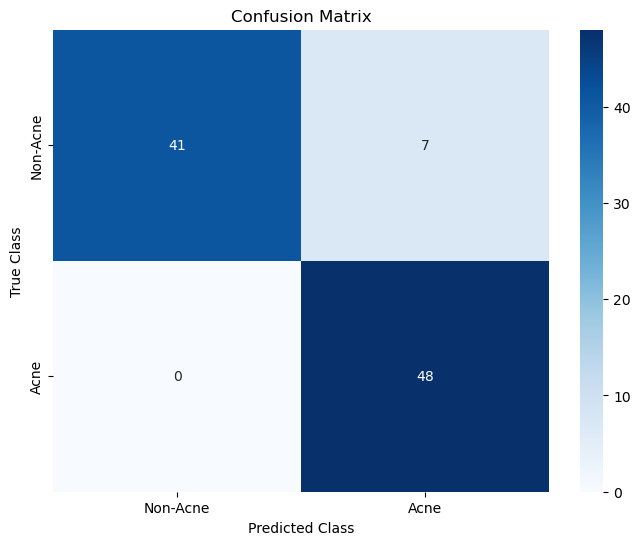

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assume true_labels and predicted_labels are already defined as in the previous example

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names
class_names = ['Non-Acne', 'Acne']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


 ### ROC Curve and AUC (Area Under the Curve)

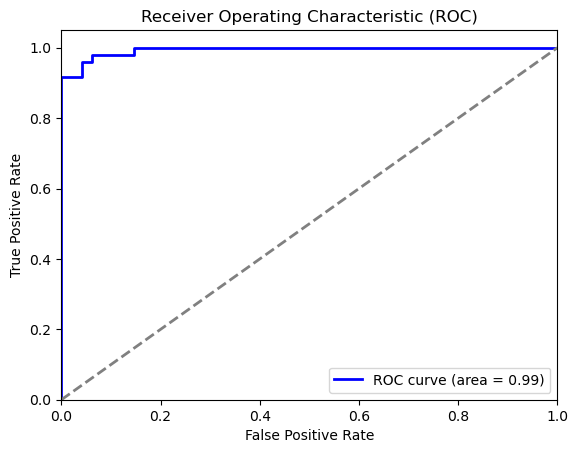

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


### Precision vs Recall vs F1-Score

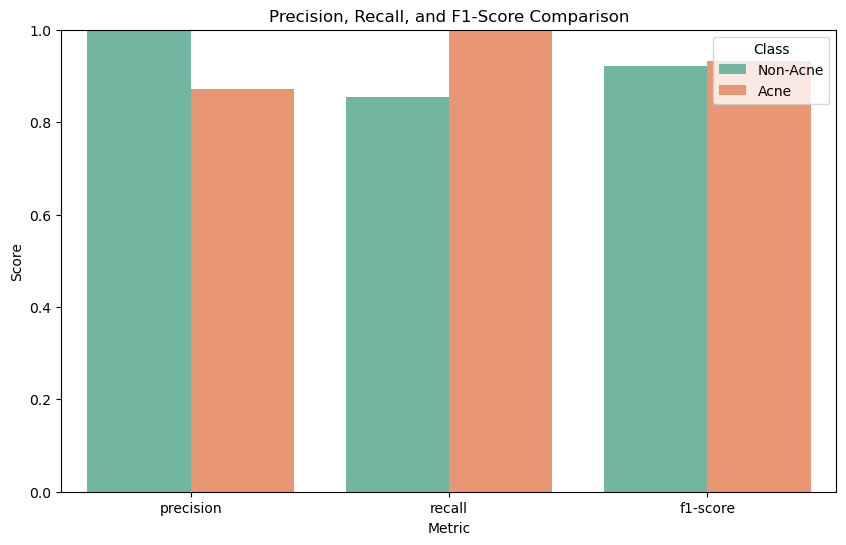

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Assuming true_labels and predicted_labels are defined
# true_labels: Actual labels
# predicted_labels: Predicted labels by the model

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=['Non-Acne', 'Acne'], output_dict=True)

# Extract Precision, Recall, and F1-Score for each class
metrics = ['precision', 'recall', 'f1-score']
classes = ['Non-Acne', 'Acne']
values = {metric: [report[class_name][metric] for class_name in classes] for metric in metrics}

# Convert to a format suitable for seaborn
metrics_data = []
for metric, scores in values.items():
    for score, class_name in zip(scores, classes):
        metrics_data.append({'Metric': metric, 'Class': class_name, 'Score': score})

# Create a DataFrame
import pandas as pd
df_metrics = pd.DataFrame(metrics_data)

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Class', data=df_metrics, palette='Set2')
plt.title('Precision, Recall, and F1-Score Comparison')
plt.ylim(0, 1)  # All metrics are between 0 and 1
plt.ylabel('Score')
plt.show()


### Matthews Correlation Coefficient (MCC)

These metrics provide a more comprehensive evaluation of your model's performance, helping to understand its strengths and weaknesses, especially in the context of medical diagnostics where accurate classification is critical.

In [14]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(true_labels, predicted_labels)
print(f'MCC: {mcc:.2f}')


MCC: 0.86


### Making predictions using a single image

In [15]:
# Import necessary libraries
import numpy as np  # For numerical operations
from tensorflow.keras.preprocessing import image  # For image preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input  # For VGG16-specific preprocessing
from tensorflow.keras.models import load_model  # For loading a saved model

# Load and preprocess the image
img_path = "dataset/testing/acne/acne-7_jpeg.rf.34ee37b930f592f787bb8d1bf6b37d30.jpg"  # Path to the image file
img = image.load_img(img_path, target_size=(224, 224))  # Load the image and resize it to 224x224 pixels
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension (1, 224, 224, 3)
img_array = preprocess_input(img_array)  # Apply VGG16-specific preprocessing (scaling pixel values)

# Make a prediction using the trained model
prediction = model.predict(img_array)  # Get the predicted probability from the model
prediction_class = (prediction > 0.5).astype(int)  # Convert probability to binary class label

# Map prediction to class label
class_labels = ['Non-Acne', 'Acne']  # Define the class labels
predicted_label = class_labels[prediction_class[0][0]]  # Get the predicted class label

# Print the predicted class label
print(f'Predicted Label: {predicted_label}')  # Output the predicted label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Predicted Label: Non-Acne


### Saving the Model

In [16]:
from tensorflow.keras.models import save_model

# Assuming `model` is your trained Keras model
model.save('VGG16Model.h5')  # Save model to HDF5 file


### Loading the Model

In [18]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('VGG16Model.h5')

### Testing Acne

In [23]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image  # For image preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input  # For VGG16-specific preprocessing
from tensorflow.keras.models import load_model  # For loading a saved model

# Define the directory path
acne_path = "/home/agbor/Public/Deep Learning Projects/Tom Aniebet/Acne Detection/dataset/testing/acne"

# Get a list of all files and directories in the specified directory
all_acne_files = os.listdir(acne_path)

# Filter out only files
acne_files = [f for f in all_acne_files if os.path.isfile(os.path.join(acne_path, f))]

# Load the model from the file
acne = load_model('VGG16Model.h5')

# Iterate over each file in the acne directory
for file_name in acne_files:
    # Load and preprocess the image
    img_path = os.path.join(acne_path, file_name)  # Construct the full path to the image
    img = image.load_img(img_path, target_size=(224, 224))  # Load the image and resize it
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension (1, 224, 224, 3)
    img_array = preprocess_input(img_array)  # Apply VGG16-specific preprocessing

    # Make a prediction using the trained model
    prediction = acne.predict(img_array)  # Get the predicted probability from the model
    prediction_class = (prediction > 0.5).astype(int)  # Convert probability to binary class label

    # Map prediction to class label
    class_labels = ['Acne', 'Non-Acne']  # Define the class labels
    predicted_label = class_labels[prediction_class[0][0]]  # Get the predicted class label

    # Print the predicted class label
    print(f'Predicted Label for {file_name}: {predicted_label}')  # Output the predicted label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Predicted Label for acne-286_jpeg.rf.1b6bcca440593ac6e33617083f34a4c5.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted Label for acne-422_jpeg.rf.c90a75e149931778d9c643273737df59.jpg: Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Predicted Label for acne-276_jpeg.rf.9d0990f99dee0e0ec17d89fd07384e0b.jpg: Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Predicted Label for acne-140_jpg.rf.785b2c29676c422c6a1cdbe6708f86e8.jpg: Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Label for acne-84_jpeg.rf.040421ad53965f5f41ddc6f6a8edef9f.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Predicted Label for acne-60_jpeg.rf.f2694c8e6226c725ff40b771560b5e06.jpg: Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predicted Label for acne-25_jpeg.rf.61edfe1eaf01bce48403a1a22f693a86.jpg: Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted Label for acne-32_jpeg.rf.6cfebd1da197182fd10391fc051d7308.jpg: Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Predic

### Testing all the Non-acne files

In [24]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image  # For image preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input  # For VGG16-specific preprocessing
from tensorflow.keras.models import load_model  # For loading a saved model


# Define the directory path
non_acne_path = "/home/agbor/Public/Deep Learning Projects/Tom Aniebet/Acne Detection/dataset/testing/skin"

# Get a list of all files and directories in the specified directory
non_acne_files = os.listdir(non_acne_path)

# Filter out only files
non_acne_files = [f for f in non_acne_files if os.path.isfile(os.path.join(non_acne_path, f))]


# Load the model from the file
non_acne = load_model('VGG16Model.h5')

# Iterate over each file in the acne directory
for file_name in non_acne_files:
    try:
    

        # Load and preprocess the image
        img_path = os.path.join(non_acne_path, file_name)  # Construct the full path to the image
        img = image.load_img(img_path, target_size=(224, 224))  # Load the image and resize it
        img_array = image.img_to_array(img)  # Convert the image to a numpy array
        img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension (1, 224, 224, 3)
        img_array = preprocess_input(img_array)  # Apply VGG16-specific preprocessing

        # Make a prediction using the trained model
        prediction = non_acne.predict(img_array)  # Get the predicted probability from the model
        prediction_class = (prediction > 0.5).astype(int)  # Convert probability to binary class label
        # Map prediction to class label
        class_labels = ['Acne', 'Non-Acne']  # Define the class labels
        predicted_label = class_labels[prediction_class[0][0]]  # Get the predicted class label

        # Print the predicted class label
        print(f'Predicted Label for {file_name}: {predicted_label}')  # Output the predicted label
    except Exception as e:
            print(f"Error processing {file_name}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Predicted Label for actinic-keratosis-5FU-5.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predicted Label for eczema-hand-188.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicted Label for basal-cell-carcinoma-lesion-109.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Predicted Label for stasis-dermatitis-169.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted Label for actinic-keratosis-5FU-25.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Label for basal-cell-carcinoma-lesion-94.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Label for actinic-cheilitis-sq-cell-lip-54.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Predicted Label for eczema-hand-133.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Predicted Label for eczema-hyperkeratotic-2.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Label for eczema-hand-14.jpg: Non-Acne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173m

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# Load the model
model = load_model('VGG16Model.h5')

def predict_acne_severity(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Ensure the size matches your model's input size
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    
    print(f"Prediction shape: {prediction.shape}")
    print(f"Prediction values: {prediction}")

    severity = np.argmax(prediction, axis=1)[0]  # Adjust if model outputs differently
    return severity

# Test the prediction function
severity = predict_acne_severity('/home/agbor/Public/Deep Learning Projects/Tom Aniebet/Acne Detection/dataset/testing/acne/acne-355_jpeg.rf.a407ad30612ee0eea150efed8772694d.jpg')
print(f"Predicted severity: {severity}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Prediction shape: (1, 1)
Prediction values: [[0.00053286]]
Predicted severity: 0
